# Predicting Useful Questions on Stack Exchange #

For this project, we are working with question data from Stack Exchange, specifically from Stack Exchange's Cross Validated site. The data contains all the questions asked during the year 2020. Below is a description of the features in our dataset.

- **Title:**
    - Title text of the question
- **Body:**
    - Main body text of the question (in html format)
- **Tags:**
    - List of tags associated with the question (the format is \<tag1>\<tag2>...)
- **Score:**
    - Score of the question, equal to total number of upvotes minus total number of downvotes


In this project we will build a model that predicts whether or not a question is useful (we will define "useful" as a question with a score greater than 0). Such a model would be desirable for Stack Exchange because they can use it promote certain questions at the top of their page, which would make browsing their websites more convenient for their users.   

## Data Cleaning/Feature Extraction ##

We will use a bag of words model to represent the text in our data set. Before we can do this though, we will have to clean up the text data.  

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import nltk

In [2]:
#nltk.download('punkt')

In [3]:
train=pd.read_csv("stack_stats_2020_train.csv")
test=pd.read_csv("stack_stats_2020_test.csv")

In [4]:
combined=pd.concat((train,test))
combined

,Id,Score,Body,Title,Tags
0,495560,1,<p>I have a set of data that I am transforming...,R: emmeans back tranform clr data using clrInv,<r><mixed-model><linear><lsmeans>
1,489896,0,<p>We are sending a one bit message to someone...,Trying to determine the failure rate of redund...,<probability><python>
2,497951,2,<p>I am aware that there is a similar post: <a...,How to derive categorical cross entropy update...,<logistic><cross-entropy>
3,478542,2,<p>I have a Poisson distributed glm where I ha...,"Learning more about glm parameters, how to dig...",<generalized-linear-model><interpretation>
4,458388,0,<p>1) how do i decide which transformation or ...,Is there I guide to decide which transformatio...,<python><data-transformation><dataset><feature...
...,...,...,...,...,...
8244,450701,0,"<p>My data is of the form <span class=""math-co...",Visualising high dimensional data,<r><data-visualization><ggplot2>
8245,481194,1,<p>I noticed the term ANOVA used in many conte...,Is the analysis of residual variance still ANO...,<regression><anova><generalized-linear-model><...
8246,492163,3,"<p>I'm trying to do logistic regression, but I...",Handling missing data in logistic regression,<r><regression><logistic><missing-data><regres...
8247,451444,2,<p>Consider the following experimental design ...,Mixed models: How to treat random factors that...,<r><mixed-model><lme4-nlme>


As you can see above, I first combine our training set and test set. I do this only because we want our bag of words representations of the training and test sets to record the frequencies of the same words (if we proccessed these sets seperately there may be words in the test set that don't appear in the training set and vice versa). This consistency between the two sets is important for when we actually use machine learning models to preform classification. After the bag of words model is created, I will seperate the data back into the same training and test sets.

The following code cell contains the necessary code to clean up the text. This includes making all the letters lower case, removing stop words, digits, and punctuation, and stemming each word. Also, there were some special considerations that needed to be made for the body text and the tag text.

Since the body text is in HTML format, I first used the BeautifulSoup package extract the relevant text then wrote a line of code to remove any lingering '\n'. I noticed a lot of latex expressions in the body text so I wrote some code that stripped all of the body text of latex expressions using a regex. I decided to remove latex expressions from the text because they are comprised of a lot of symbols that don't have any semantic meaning in the english language.

As for the tag text, I made the decision to tokenize each word based off each tag a question had. I also didn't bother removing the hyphen in hyphenated words. My reasoning behind this is that I believe that the tags in a question would lose its semantic meaning if we were to break up the phrases in each tag and look at each term individually. For example, the tag \<random-forest> signals that the question is going to be about the random forest model. If we were to break down the tag into the two terms "random" and "forest", maybe the model we train would be able to deduce that the presence of the word "forest" may signal a question about random forests, but the word "random" can be used in different contexts that don't align with the topic of random forests. Therefore, I chose to keep phrases in tags together to avoid this problem.

In [5]:
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

remove_punctuation= lambda document:''.join([character for character in document if character not in punctuation])

remove_digit= lambda document:''.join([character for character in document if not character.isdigit()])

stop_words = set(stopwords.words('english'))
remove_stopwords=lambda document:[word for word in document if not word in stop_words]


stemmer= lambda document:[PorterStemmer().stem(word) for word in document]

def clean_body(series):
    t=pd.Series([BeautifulSoup(series.iloc[i],'html.parser').get_text() for i in range(len(series))],index=series.index)
    t=t.str.replace('\n',' ', regex=False)
    t=t.str.replace('[$]{2}.*?[$]{2}',' ',regex=True)
    t=t.str.replace('[$].*?[$]',' ',regex=True)
    t=t.str.lower()
    t=t.apply(remove_punctuation)
    t=t.apply(remove_digit)
    t=t.apply(word_tokenize)
    t=t.apply(remove_stopwords)
    t=t.apply(stemmer)
    
    return t.apply(' '.join)

def clean_tag(series):
    tk = RegexpTokenizer('[<].*?[>]', gaps = False)
    series=series.apply(tk.tokenize)
    series=series.apply(" ".join)
    f=lambda s:''.join([c for c in s if c not in ['<','>']])
    series=series.apply(f)
    return series

def clean_title(t):
    t=t.str.lower()
    t=t.apply(remove_punctuation)
    t=t.apply(remove_digit)
    t=t.apply(word_tokenize)
    t=t.apply(remove_stopwords)
    t=t.apply(stemmer)
    return t.apply(' '.join)
    
 

In [6]:
body=clean_body(combined["Body"])
title=clean_title(combined["Title"])
tag=clean_tag(combined["Tags"])


Now that the text is clean we can go about creating a document term matrix. I made the decision of processing the three types of text data in our dataset independently. I did this because certain words may have different implications depending on if the word was found in the title, body, or tag. The following two code cells creates three document term matrices for each text type and concatenates them to produce the final dataset we will be working with. By passing in the min_df parameter into sklearn's CountVectorizer I was able to limit the bag of words model to only consider words that appear in at least 3% of the corpus (I chose to do 5% specifically for the tag text). This rids the matrix of insignificant terms and also limits the amount of features we will have down to a manageable size, which ended up being 396. 

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

countvec = CountVectorizer(min_df=0.03)

df_b=countvec.fit_transform(body)
df_b=pd.DataFrame(df_b.toarray(),columns=pd.Series(countvec.get_feature_names()).apply(lambda x: x+"_Body"),index=body.index)

df_tit=countvec.fit_transform(title)
df_tit=pd.DataFrame(df_tit.toarray(),columns=pd.Series(countvec.get_feature_names()).apply(lambda x: x+"_Title"),index=title.index)

countvec = CountVectorizer(min_df=0.05,token_pattern='\w+(?:-\w+)*|\$[\d.]+|\S+')
df_tag=countvec.fit_transform(tag)
df_tag=pd.DataFrame(df_tag.toarray(),columns=pd.Series(countvec.get_feature_names()).apply(lambda x: x+"_Tags"),index=tag.index)


In [8]:
data=pd.concat([df_b,df_tit,df_tag],axis=1)
X=data.iloc[:len(train),:]
processed_test=data.iloc[len(train):,:]
y=train['Score']>0
test_y=test['Score']>0

In [9]:
X

,abl_Body,accord_Body,account_Body,accuraci_Body,across_Body,actual_Body,ad_Body,add_Body,addit_Body,advanc_Body,...,two_Title,use_Title,valu_Title,variabl_Title,machine-learning_Tags,neural-networks_Tags,probability_Tags,r_Tags,regression_Tags,time-series_Tags
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19242,2,0,0,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
19243,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
19244,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19245,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


## Model Building/Evaluation ##

For this phase, we will train and evaluate a list of models and decide which one would be most appropriate for the task at hand. The function below takes in a model and reports a list metrics using cross validation on the training set. The metrics I chose to report were accuracy, recall, precision, and the area under the receiver operating characteristic curve (AUC).

In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import KFold



def get_score(model,K=5,drop=[]):
    X1=X.drop(columns=drop)
    scores={"Accuracy":[],"Recall":[],"Precision":[],"AUC":[]}
    for tra, val in KFold(n_splits=K).split(X1):
        model.fit(X1.iloc[tra,:],y.iloc[tra])
        tru=y.iloc[val]
        pred=model.predict(X1.iloc[val,:])
        scores["Accuracy"].append(accuracy_score(tru,pred))
        scores["Recall"].append(recall_score(tru,pred))
        scores["Precision"].append(precision_score(tru,pred))
        scores["AUC"].append(roc_auc_score(tru,pred))
    model.fit(X1,y)
    
    
    print(str(K)+"-Fold Cross Validation Results:")
    for metric in scores.keys():
        print(metric+ ":",np.mean(scores[metric]))
    

### Linear Discriminant Analysis ###

No special considerations or hyperparameters are present for linear discriminant analysis.

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda=LinearDiscriminantAnalysis()
get_score(lda,K=10)

10-Fold Cross Validation Results:
Accuracy: 0.5630480600480601
Recall: 0.5021241221544981
Precision: 0.5682341838612952
AUC: 0.5627535773066221


### Logistic Regression ###

For the logistic regression model, we can conduct a hypothesis test to see if we have any irrelevant features in our data. We do this by calculating the p-values for each feature's coefficient (a very low p-value signals that the coefficient is significantly different from zero). We will regard coefficients with a p-values less than or equal 5% as statistically significant. The following code cell repeatedly fits a logistic regression model on our training data. Each time it fits a model, it calculates the p-values of the coefficients and drops the feature in our dataset with highest p-value. It does this until all the features in our data are statistically significant. 

In [12]:
import statsmodels.api as sm

def stepwise_logistic_regression():
    X1=sm.add_constant(X)
    cols=X1.columns
    flag=True
    dropped=[]
    while flag:
        model=sm.Logit(y,X1[cols]).fit(disp=False)
        if all(model.pvalues<=0.05):
            flag=False
        else:
            label=model.pvalues[model.pvalues==max(model.pvalues)].index[0]
            dropped.append(label)
            cols=[e for e in cols if e!=label]
    return model,dropped

logistic,log_dropped=stepwise_logistic_regression()
            

Another metric we can use to evaluate each feature is the variance inflation factor (VIF). It gives us a sense of the multicollinearity amongst the features, which is a potential issue for logistic regression. The VIF of each feature remaining after dropping all of the insignificant ones is reported below.

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

VIF(X.drop(columns=log_dropped),X.drop(columns=log_dropped).columns)

alway_Body          1.020062
analysi_Body        1.068963
answer_Body         1.013166
anyon_Body          1.012876
appreci_Body        1.027126
                      ...   
interpret_Title     1.020233
multipl_Title       1.016212
predict_Title       1.015363
test_Title          1.089030
probability_Tags    1.048305
Length: 64, dtype: float64

No further features need to be dropped since all of the VIF's are about 1.

In [14]:
from sklearn.linear_model import LogisticRegression

log=LogisticRegression()
get_score(log,drop=log_dropped,K=10)


10-Fold Cross Validation Results:
Accuracy: 0.5825318195318195
Recall: 0.4990861841498758
Precision: 0.5953433734082617
AUC: 0.5821231724856676


For the next three models we will consider, we need to decide on certain hyperparameters. We will verify the choice of hyperparameters using cross validation. The choice of hyperparameters will be optimized with the goal of maximizing **AUC**.    

One way we can interpret AUC is given a random useful question and a random non-useful question in our dataset, the AUC is the probability that the model will return a higher probability value for the useful question than the non-useful question. Since our ultimate task of this project is to list useful questions at the top of Stack Exchange's websites, this is indeed the best metric to optimize for. We can make our models return probabilities for each question being useful and list the questions from highest probabilities to lowest. The higher a model's AUC, the more confident we are that the top of the page has more useful questions than the bottom.

Furthermore, the next three models are all based off of the decision tree model (random forests and gradient boosting are ensemble methods that aggregate decision trees). Because of this, for each feature in our data we will have access to it's gini importance, which measures the average gain of purity by splits of a given feature. A feature with a high gini importance means that when a split in a decision tree is made using that feature, it tends to result in nodes with higher purity (i.e. nodes that mostly consist of one type of class that we are predicting). Utilizing this knowledge, we will choose to train each of the following models with the 70 most gini important features in the data. The function below does this and reports the cross validated scores of the model. 

In [15]:
def treemodel_score(model,threshold,K=5):
    model.fit(X,y)
    imp=pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)
    d=imp.tail(396-threshold).index

    get_score(model,drop=d,K=K)
    return list(d)

### Decision Tree (CART) ###

Below are the scores for a CART model using sklearn's default hyperparameters followed by the scores for a CART model with the same hyperparameters but now only considering the 70 features with highest gini importance.

In [16]:
from sklearn.tree import DecisionTreeClassifier

default_cart=DecisionTreeClassifier(random_state=45)
get_score(default_cart,K=10)

10-Fold Cross Validation Results:
Accuracy: 0.5146772956772956
Recall: 0.5145127001556569
Precision: 0.5116354043360184
AUC: 0.5147826312909409


In [17]:
cart_dropped=treemodel_score(default_cart,70,K=10)

10-Fold Cross Validation Results:
Accuracy: 0.5116131706131706
Recall: 0.5232048142484285
Precision: 0.5082190091831076
AUC: 0.5116722259436087


Though there's a very slight drop off in our performace metrics, the second model performs relatively the same as the first and is only considering 70 of the 396 features the first one considers. Dropping off those irrelevant features will reduce the chances of overfitting. 

Now that we have identified the specific features we want to train on, we will tune the relevant hyperparameters with the intent of maximizing AUC then report the cross validated scores once more.

In [18]:
from sklearn.model_selection import GridSearchCV

grid_values = {'ccp_alpha': np.linspace(0, 0.05, 101)}

cart=DecisionTreeClassifier(random_state=45)
cart=GridSearchCV(cart,param_grid=grid_values,scoring='roc_auc').fit(X.drop(columns=cart_dropped),y)

In [19]:
print("Best parameters:",cart.best_params_)
print()
get_score(cart.best_estimator_,drop=cart_dropped,K=10)

Best parameters: {'ccp_alpha': 0.0005}

10-Fold Cross Validation Results:
Accuracy: 0.5324460674460674
Recall: 0.43086418048157515
Precision: 0.5396716472608789
AUC: 0.5321145631142928


The same approach is utilized for the next two models. 

### Random Forest ###

In [20]:
from sklearn.ensemble import RandomForestClassifier

default_rf=RandomForestClassifier(random_state=45)
get_score(default_cart,K=10)



10-Fold Cross Validation Results:
Accuracy: 0.5146772956772956
Recall: 0.5145127001556569
Precision: 0.5116354043360184
AUC: 0.5147826312909409


In [21]:
rf_dropped=treemodel_score(default_rf,70,K=10)

10-Fold Cross Validation Results:
Accuracy: 0.5479286389286389
Recall: 0.5184224111079081
Precision: 0.5475353741626467
AUC: 0.5477570475534831


In [22]:
grid_values = {'max_depth': range(10,170,30),
               'n_estimators': range(100,701,100)
              }

rf=RandomForestClassifier(random_state=45)
rf=GridSearchCV(rf,param_grid=grid_values,scoring='roc_auc').fit(X.drop(columns=rf_dropped),y)

In [23]:
print("Best parameters:",rf.best_params_)
print()
get_score(rf.best_estimator_,drop=rf_dropped,K=10)

Best parameters: {'max_depth': 10, 'n_estimators': 700}

10-Fold Cross Validation Results:
Accuracy: 0.5636193536193536
Recall: 0.45520212300968277
Precision: 0.5775296565853163
AUC: 0.5631984894238374


### Gradient Boosting ###

In [24]:
from sklearn.ensemble import GradientBoostingClassifier


default_boost=GradientBoostingClassifier(random_state=45)
get_score(default_boost,K=10)


10-Fold Cross Validation Results:
Accuracy: 0.565906390906391
Recall: 0.46973424644885975
Precision: 0.57787436934879
AUC: 0.565465209982628


In [25]:
boost_dropped=treemodel_score(default_boost,70,K=10)

10-Fold Cross Validation Results:
Accuracy: 0.5748419148419149
Recall: 0.4832605600918479
Precision: 0.5879923827284025
AUC: 0.5744470066996581


In [26]:
grid_values={'learning_rate':np.linspace(.001,.2,20),
              'n_estimators':range(100,501,100),
              'max_depth':[1,2,3]
             }

boost=GradientBoostingClassifier(random_state=45)
boost=GridSearchCV(boost,param_grid=grid_values,scoring='roc_auc').fit(X.drop(columns=boost_dropped),y)


In [27]:
print("Best parameters:",boost.best_params_)
print()
get_score(boost.best_estimator_,drop=boost_dropped,K=10)

Best parameters: {'learning_rate': 0.15810526315789475, 'max_depth': 2, 'n_estimators': 300}

10-Fold Cross Validation Results:
Accuracy: 0.5781157761157761
Recall: 0.5036727063781503
Precision: 0.5881982439856421
AUC: 0.5777663322967228


## Test Set Metrics ##

We now have the option to simply calculate our performance metrics on the test set data. However, since the testing data is only a sample of the true population, there will be some uncertainty associated with any performance metric computed on the test data. Instead we will take bootstrap samples of our test set and calcuate the metric values for each sample to produce a distribution for each metric. This method will give us sense of the variability of our performance metrics.   

In [28]:
import time

def bootstrap_validation(test_data, test_label, models,drops,sample=500):
    
    n_sample = sample
    output_array=np.zeros([4*n_sample, len(models)])
    output_array[:]=np.nan
    
    tic = time.time()
    for bs_iter in range(n_sample):
        #if bs_iter % 100 == 0:
        #     print(bs_iter, round(time.time()-tic))
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        for model_iter in range(len(models)):
            model = list(models.values())[model_iter]
            bs_predicted = model.predict(bs_data.drop(columns=drops[model_iter]))
            output_array[bs_iter*4, model_iter]=accuracy_score(bs_label,bs_predicted)
            output_array[bs_iter*4+1, model_iter]=recall_score(bs_label,bs_predicted)
            output_array[bs_iter*4+2, model_iter]=precision_score(bs_label,bs_predicted)
            output_array[bs_iter*4+3, model_iter]=roc_auc_score(bs_label,bs_predicted)

        
                
    index = pd.MultiIndex.from_product([range(500),['Accuracy','Recall',"Precision","AUC"]],names=["Bootstrap Sample", "Metric"])
    output_df = pd.DataFrame(output_array,index=index,columns=models.keys())
    return output_df

def CI_95(data):
    return np.percentile(data,2.5), np.percentile(data,97.5)

In [29]:
models={"Linear Discriminant Analysis":lda,"Logistic Regression":log, "CART":cart,"Random Forest":rf,"Boosting":boost}
drops=[[],log_dropped,cart_dropped,rf_dropped,boost_dropped]

bs=bootstrap_validation(processed_test,test_y,models,drops)

In [30]:
bs

Linear Discriminant Analysis  Logistic Regression  \
Bootstrap Sample Metric                                                         
0                Accuracy                       0.572312             0.574615   
                 Recall                         0.506326             0.484672   
                 Precision                      0.581285             0.588826   
                 AUC                            0.572081             0.574300   
1                Accuracy                       0.572191             0.573524   
...                                                  ...                  ...   
498              AUC                            0.569306             0.572419   
499              Accuracy                       0.569524             0.570615   
                 Recall                         0.509872             0.495558   
                 Precision                      0.568989             0.572732   
                 AUC                            0.568493             0.569318   

                                CART  Random Forest  Boosting  
Bootstrap Sample Metric                                        
0                Accuracy   0.550733       0.567584  0.569402  
                 Recall     0.473236       0.442579  0.491971  
                 Precision  0.557946       0.587722  0.580034  
                 AUC        0.550462       0.567146  0.569131  
1                Accuracy   0.545642       0.559219  0.564675  
...                              ...            ...       ...  
498              AUC        0.541166       0.572846  0.575920  
499              Accuracy   0.545036       0.563220  0.566978  
                 Recall     0.461007       0.449654  0.489635  
                 Precision  0.543497       0.570266  0.568807  
                 AUC        0.543584       0.561258  0.565642  

[2000 rows x 5 columns]

In [31]:
print("Accuracy Bootstrap Estimate:")
acc=bs.swaplevel().loc['Accuracy']
acc.mean()

Accuracy Bootstrap Estimate:


Linear Discriminant Analysis    0.570653
Logistic Regression             0.574824
CART                            0.545006
Random Forest                   0.566277
Boosting                        0.568987
dtype: float64

In [32]:
print("Recall Bootstrap Estimate:")
TPR=bs.swaplevel().loc['Recall']
TPR.mean()

Recall Bootstrap Estimate:


Linear Discriminant Analysis    0.504492
Logistic Regression             0.488338
CART                            0.464108
Random Forest                   0.445752
Boosting                        0.488554
dtype: float64

In [33]:
print("Precision Bootstrap Estimate:")
prec=bs.swaplevel().loc['Precision']
prec.mean()

Precision Bootstrap Estimate:


Linear Discriminant Analysis    0.567195
Logistic Regression             0.575477
CART                            0.538864
Random Forest                   0.570781
Boosting                        0.567428
dtype: float64

In [34]:
print("AUC Bootstrap Estimate:")
AUC=bs.swaplevel().loc['AUC']
AUC.mean()

AUC Bootstrap Estimate:


Linear Discriminant Analysis    0.569057
Logistic Regression             0.572737
CART                            0.543056
Random Forest                   0.563369
Boosting                        0.567045
dtype: float64

The bootstrap data also allows us to construct confidence intervals. The code cell below displays the 95% confidence intervals of the difference between AUC of the model with the highest bootstrapped AUC (logistic regression) and all the other models. 

In [35]:
print('Linear Discriminant Analysis:',CI_95(AUC['Logistic Regression']-AUC['Linear Discriminant Analysis']))
print('CART:',CI_95(AUC['Logistic Regression']-AUC['CART']))
print('Random Forest:',CI_95(AUC['Logistic Regression']-AUC['Random Forest']))
print('Boosting:',CI_95(AUC['Logistic Regression']-AUC['Boosting']))

Linear Discriminant Analysis: (-0.005056645270223895, 0.013424884741978546)
CART: (0.017634468604393536, 0.041715566224246714)
Random Forest: (-0.0018424170054883002, 0.019959956582789703)
Boosting: (-0.0025878105847576436, 0.015033787110281967)


One of the intervals do not contain 0. This signals that the gradient boosting model's AUC is significantly better than the CART model. This means that our choice of model will probably be one of the other models.   

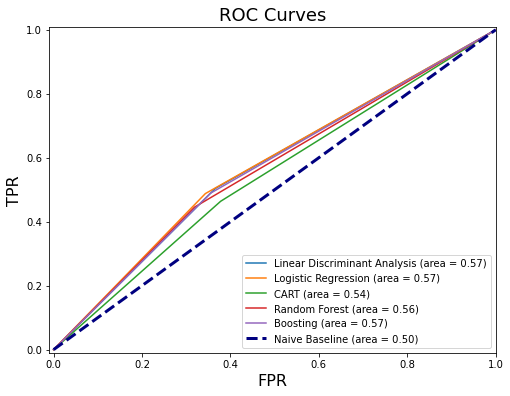

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title('ROC Curves', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])

for model_iter in range(len(models)):
    model = list(models.values())[model_iter]
    t=processed_test.drop(columns=drops[model_iter])
    fpr, tpr, _ = roc_curve(test_y,model.predict(t))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.5,label=list(models.keys())[model_iter]+' (area = {:0.2f})'.format(roc_auc))



plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=10)
plt.show()

The ROC curves of each model on the test set data further support our initial inference from the confidence intervals. We see that the CART ROC curve is below the four other models' curves, while the four other models have nearly identical curves and AUC.

## Results ##

In order to get a sense of how well our model will perform the given task of promoting useful questions at the top of the page, we will run a simulation that estimates the increase in probability that the top question is useful. StackExchange's CrossValidated site lists 15 recently posted questions on the first page of the website. The naive approach would be to list the most recent posts at the top and the older posts towards the bottom. For the purposes of the simulation, we can treat the naive approach as a random sample of 15 from our test set. To calculate the increase of probability, we will run a simulation 10,000 times. On each run, will take a random sample of 15 from our test set, check to see if the first question in the sample is useful, then rank the questions based off the probabilities our models return and check to see if the question with the highest probability (the question our model would recommend to have on the top of the page) is useful. Calculating the proportion of times that each event occurs will serve as our estimated probabilities.

In [37]:
random_count=0
model_counts=dict(zip(models.keys(),np.zeros(5)))
N=10000

tic = time.time()
for _ in range(N):
#    if _%1000==0:
#        print(_,round(time.time()-tic))
    index=np.random.choice(test.index, 15, replace=True)
    questions=processed_test.loc[index]
    labels=test_y.loc[index]
    if labels.iloc[0]==1:
        random_count+=1
    for model_iter in range(len(models)):
        model=list(models.values())[model_iter]
        probs=model.predict_proba(questions.drop(columns=drops[model_iter]))[:,1]
        best_index=max(zip(index,probs),key=lambda x:x[1])[0]
        if labels.loc[[best_index]].iloc[0]==1:
            model_counts[list(models.keys())[model_iter]]+=1
random_prob=random_count/N




In [38]:
model_probs={}
for m in model_counts:
    model_probs[m]=model_counts[m]/N
    print("The increase in probability by using the "+m+" model: "+str(round(
        100*(model_probs[m]-random_prob),2))+"%")

The increase in probability by using the Linear Discriminant Analysis model: 16.07%
The increase in probability by using the Logistic Regression model: 16.83%
The increase in probability by using the CART model: 9.2%
The increase in probability by using the Random Forest model: 15.23%
The increase in probability by using the Boosting model: 15.32%


The best increase of probability was about 17% and came from the Logistic Regression model.

## Conclusion ##

Though the logistic regression model performed the best in the simulation, it is possibile that another one of the models could perform better when deployed on future data. However, we can confidently say that the CART model would most likely not be one of those models due to the confidence interval we computed during bootstrapping. 

A potential way we could improve the results is tweaking the min_df parameter in CountVectorizer, which would increase/decrease the amount of words the document term matrix considers. Also, it appears that there's a limit to what we can achieve with bag of words model; perhaps we can consider a more complex representation of the text such as a word embedding and see if that improves our results.